In [1]:
!pip install torchsummary

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torchsummary import summary
import os

### Functions & utilities

In [5]:
def plot_random_mnist_images(test_loader, num_images=49):
    # Gather all images and labels from the test loader
    all_images, all_labels = [], []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)

    # Combine all batches into single tensors
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Select random indices
    indices = random.sample(range(len(all_images)), num_images)

    # Plot the selected images
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(7, 7, i + 1)  # Adjust grid size to fit images
        plt.imshow(all_images[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(str(all_labels[idx].item()))

    plt.tight_layout()
    plt.show()

In [3]:
from tqdm import tqdm
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        # Compute loss
        loss = F.nll_loss(output, target)
        train_loss += loss.item() * data.size(0)  # accumulate batch loss
        
        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        pbar.set_description(desc=f"loss={loss.item():.4f} batch_id={batch_idx}")

    # Compute average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = 100.0 * correct / total

    print(f"\nEpoch {epoch}: Train set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n")
    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            
            # Compute accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute average loss and accuracy for the test set
    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy


In [4]:
## Checking if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [5]:
## Checking number of cores available
import multiprocessing
multiprocessing.cpu_count()

4

### Loading MNIST Data

In [8]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
batch_size = 512
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

### Creating Base Model
* Aim in this step is to create a based model first which adhere to the constraints of less than 8k parametes
* No major data transformation is used except for normalization
* We will closely monitor the train and test accuracy and loss to understand the model performance
* In assignment 6 we observed one key point around LR schedueler. It significantly improves the training loss convergence. We will use the same here

In [9]:
class MiniCNN_1(nn.Module):
    def __init__(self):
        super(MiniCNN_1, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 28,1>28,8|RF:3,J:1
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 28,8>28,8|RF:5,J:1
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 28,8>28,8|RF:7,J:1
            nn.ReLU(),
        )
        self.pool_1 = nn.MaxPool2d(2, 2)  # 28,8>14,8|RF:8,J:2
        self.transition_1 = nn.Conv2d(
            in_channels=8, out_channels=4, kernel_size=(1, 1), padding=0, bias=False
        )  # 14,8>14,4|RF:8,J:2
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 14,4>14,8|RF:12,J:2
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),  # 14,8>14,16|RF:16,J:2
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),  # 14,16>14,16|RF:20,J:2
            nn.ReLU(),
        )
        self.pool_2 = nn.MaxPool2d(2, 2)  # 14,16>7,16|RF:21,J:4
        self.transition_2 = nn.Conv2d(
            in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False
        )  # 14,16>7,4|RF:21,J:4
        self.fc = nn.Linear(4 * 7 * 7, 10)  # 7,4>10

    def forward(self, x):
        x = self.block_1(x)
        x = self.pool_1(x)
        x = self.transition_1(x)
        x = self.block_2(x)
        x = self.pool_2(x)
        x = self.transition_2(x)
        x = x.view(-1, 4 * 7 * 7)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [10]:
model = MiniCNN_1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8            [-1, 4, 14, 14]              32
            Conv2d-9            [-1, 8, 14, 14]             288
             ReLU-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,152
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]           2,304
             ReLU-14           [-1, 16,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x8 | 7 | 1 | 1 |
| MaxPool1 | 28x28x8 | 14x14x8 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x8 | 14x14x4 | 8 | 2 | 2 |
| Conv4 | 14x14x4 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv1 | 7x7x16 | 7x7x4 | 21 | 4 | 4 |
| FC | 7x7x4 | 10 | - | - | - |

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)
    print("LR = ", scheduler.get_last_lr())

********* Epoch = 1 *********


loss=0.1029 batch_id=117: 100%|██████████| 118/118 [00:08<00:00, 14.32it/s]


Epoch 1: Train set: Average loss: 0.0364, Accuracy: 59276/60000 (98.79%)




Test set: Average loss: 0.0617, Accuracy: 9811/10000 (98.11%)

LR =  [0.01]
********* Epoch = 2 *********


loss=0.0275 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.86it/s]



Epoch 2: Train set: Average loss: 0.0365, Accuracy: 59299/60000 (98.83%)


Test set: Average loss: 0.0333, Accuracy: 9895/10000 (98.95%)

LR =  [0.01]
********* Epoch = 3 *********


loss=0.0506 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.36it/s]


Epoch 3: Train set: Average loss: 0.0289, Accuracy: 59443/60000 (99.07%)




Test set: Average loss: 0.0440, Accuracy: 9859/10000 (98.59%)

LR =  [0.01]
********* Epoch = 4 *********


loss=0.0319 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.26it/s]


Epoch 4: Train set: Average loss: 0.0289, Accuracy: 59438/60000 (99.06%)




Test set: Average loss: 0.0374, Accuracy: 9892/10000 (98.92%)

LR =  [0.01]
********* Epoch = 5 *********


loss=0.0723 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 17.80it/s]


Epoch 5: Train set: Average loss: 0.0279, Accuracy: 59471/60000 (99.12%)




Test set: Average loss: 0.0369, Accuracy: 9885/10000 (98.85%)

LR =  [0.001]
********* Epoch = 6 *********


loss=0.0115 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.67it/s]


Epoch 6: Train set: Average loss: 0.0139, Accuracy: 59726/60000 (99.54%)




Test set: Average loss: 0.0297, Accuracy: 9915/10000 (99.15%)

LR =  [0.001]
********* Epoch = 7 *********


loss=0.0172 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.39it/s]


Epoch 7: Train set: Average loss: 0.0089, Accuracy: 59842/60000 (99.74%)




Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.13%)

LR =  [0.001]
********* Epoch = 8 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.30it/s]


Epoch 8: Train set: Average loss: 0.0073, Accuracy: 59871/60000 (99.78%)




Test set: Average loss: 0.0316, Accuracy: 9915/10000 (99.15%)

LR =  [0.001]
********* Epoch = 9 *********


loss=0.0006 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.43it/s]


Epoch 9: Train set: Average loss: 0.0061, Accuracy: 59894/60000 (99.82%)




Test set: Average loss: 0.0326, Accuracy: 9908/10000 (99.08%)

LR =  [0.0001]
********* Epoch = 10 *********


loss=0.0042 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 17.34it/s]


Epoch 10: Train set: Average loss: 0.0046, Accuracy: 59938/60000 (99.90%)




Test set: Average loss: 0.0326, Accuracy: 9914/10000 (99.14%)

LR =  [0.0001]
********* Epoch = 11 *********


loss=0.0216 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.20it/s]


Epoch 11: Train set: Average loss: 0.0044, Accuracy: 59942/60000 (99.90%)




Test set: Average loss: 0.0328, Accuracy: 9917/10000 (99.17%)

LR =  [0.0001]
********* Epoch = 12 *********


loss=0.0047 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.33it/s]


Epoch 12: Train set: Average loss: 0.0043, Accuracy: 59940/60000 (99.90%)




Test set: Average loss: 0.0330, Accuracy: 9917/10000 (99.17%)

LR =  [0.0001]
********* Epoch = 13 *********


loss=0.0001 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.44it/s]


Epoch 13: Train set: Average loss: 0.0042, Accuracy: 59941/60000 (99.90%)




Test set: Average loss: 0.0335, Accuracy: 9916/10000 (99.16%)

LR =  [0.0001]
********* Epoch = 14 *********


loss=0.0000 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 17.29it/s]


Epoch 14: Train set: Average loss: 0.0041, Accuracy: 59948/60000 (99.91%)




Test set: Average loss: 0.0337, Accuracy: 9916/10000 (99.16%)

LR =  [1e-05]
********* Epoch = 15 *********


loss=0.0006 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 18.87it/s]


Epoch 15: Train set: Average loss: 0.0039, Accuracy: 59949/60000 (99.92%)




Test set: Average loss: 0.0338, Accuracy: 9916/10000 (99.16%)

LR =  [1e-05]


#### Observations

* Max Train accuracy: 99.92%
* Max Test accuracy: 99.17%
* Model has reached max accuracy of 99.92% on training data. It shows that model is able to learn the training data very well
* There is a significant gap between train and test accuracy. It's a severe case of over-fitting

## Regularizing model to decrease train & test accuracy gap

* We will try to address the overfitting by introducing dropouts
* Main focus is to bring train and test accuracy close.
* We will continue to adhere to the less 8k param constraint

In [34]:
class MiniCNN_2(nn.Module):
    def __init__(self):
        super(MiniCNN_2, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False), # 28,1>28,8|RF:3,J:1 
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False), # 28,8>28,8|RF:5,J:1 
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False), # 28,8>28,8|RF:7,J:1
            nn.ReLU(),            
            nn.Dropout(0.2)
        )
        self.pool_1 = nn.MaxPool2d(2, 2) # 28,8>14,8|RF 8,J:2
        self.transition_1 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=(1, 1), padding=0, bias=False) # 14,8>14,4|RF:8,J:2
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),# 14,8>14,8|RF:12,J:2
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),# 14,8>14,8|RF:16,J:2
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),# 14,8>14,16|RF:20,J:2
            nn.ReLU(),            
            nn.Dropout(0.2)
        )
        self.pool_2 = nn.MaxPool2d(2, 2)# 14,16>7,16|RF:21,J:4 
        self.transition_2 = nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False)# 14,32>7,32|RF:25,J:4
        self.fc = nn.Linear(4 * 7 * 7, 10)

    def forward(self, x):
        x = self.block_1(x)
        x = self.pool_1(x)
        x = self.transition_1(x)
        x = self.block_2(x)
        x = self.pool_2(x)        
        x = self.transition_2(x)
        x = x.view(-1, 4 * 7 * 7)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)


In [35]:
model = MiniCNN_2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
           Dropout-7            [-1, 8, 28, 28]               0
         MaxPool2d-8            [-1, 8, 14, 14]               0
            Conv2d-9            [-1, 4, 14, 14]              32
           Conv2d-10            [-1, 8, 14, 14]             288
             ReLU-11            [-1, 8, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           1,152
             ReLU-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x8 | 7 | 1 | 1 |
| MaxPool1 | 28x28x8 | 14x14x8 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x8 | 14x14x4 | 8 | 2 | 2 |
| Conv4 | 14x14x4 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv1 | 7x7x16 | 7x7x4 | 21 | 4 | 4 |
| FC | 7x7x4 | 10 | - | - | - |

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=2,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)
    print("LR = ", scheduler.get_last_lr())

********* Epoch = 1 *********


loss=0.0899 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 19.21it/s]


Epoch 1: Train set: Average loss: 0.4184, Accuracy: 52029/60000 (86.72%)




Test set: Average loss: 0.1247, Accuracy: 9704/10000 (97.04%)

LR =  [0.01]
********* Epoch = 2 *********


loss=0.0865 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.85it/s]


Epoch 2: Train set: Average loss: 0.0957, Accuracy: 58243/60000 (97.07%)




Test set: Average loss: 0.0860, Accuracy: 9771/10000 (97.71%)

LR =  [0.01]
********* Epoch = 3 *********


loss=0.0741 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 21.03it/s]


Epoch 3: Train set: Average loss: 0.0759, Accuracy: 58599/60000 (97.67%)




Test set: Average loss: 0.0689, Accuracy: 9827/10000 (98.27%)

LR =  [0.01]
********* Epoch = 4 *********


loss=0.0530 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.96it/s]


Epoch 4: Train set: Average loss: 0.0622, Accuracy: 58864/60000 (98.11%)




Test set: Average loss: 0.0691, Accuracy: 9825/10000 (98.25%)

LR =  [0.01]
********* Epoch = 5 *********


loss=0.1225 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.95it/s]


Epoch 5: Train set: Average loss: 0.0593, Accuracy: 58901/60000 (98.17%)




Test set: Average loss: 0.0624, Accuracy: 9851/10000 (98.51%)

LR =  [0.01]
********* Epoch = 6 *********


loss=0.1638 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 19.54it/s]


Epoch 6: Train set: Average loss: 0.0525, Accuracy: 59017/60000 (98.36%)




Test set: Average loss: 0.0440, Accuracy: 9876/10000 (98.76%)

LR =  [0.01]
********* Epoch = 7 *********


loss=0.0849 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 21.05it/s]


Epoch 7: Train set: Average loss: 0.0470, Accuracy: 59126/60000 (98.54%)




Test set: Average loss: 0.0574, Accuracy: 9858/10000 (98.58%)

LR =  [0.01]
********* Epoch = 8 *********


loss=0.0130 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.96it/s]


Epoch 8: Train set: Average loss: 0.0454, Accuracy: 59153/60000 (98.59%)




Test set: Average loss: 0.0346, Accuracy: 9884/10000 (98.84%)

LR =  [0.01]
********* Epoch = 9 *********


loss=0.0264 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 21.07it/s]


Epoch 9: Train set: Average loss: 0.0399, Accuracy: 59242/60000 (98.74%)




Test set: Average loss: 0.0413, Accuracy: 9882/10000 (98.82%)

LR =  [0.01]
********* Epoch = 10 *********


loss=0.0636 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.90it/s]


Epoch 10: Train set: Average loss: 0.0413, Accuracy: 59229/60000 (98.72%)




Test set: Average loss: 0.0435, Accuracy: 9880/10000 (98.80%)

LR =  [0.01]
********* Epoch = 11 *********


loss=0.0528 batch_id=117: 100%|██████████| 118/118 [00:06<00:00, 19.37it/s]


Epoch 11: Train set: Average loss: 0.0396, Accuracy: 59256/60000 (98.76%)




Test set: Average loss: 0.0364, Accuracy: 9880/10000 (98.80%)

LR =  [0.001]
********* Epoch = 12 *********


loss=0.0424 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 21.27it/s]


Epoch 12: Train set: Average loss: 0.0241, Accuracy: 59532/60000 (99.22%)




Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

LR =  [0.001]
********* Epoch = 13 *********


loss=0.0647 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.96it/s]


Epoch 13: Train set: Average loss: 0.0209, Accuracy: 59564/60000 (99.27%)




Test set: Average loss: 0.0270, Accuracy: 9912/10000 (99.12%)

LR =  [0.001]
********* Epoch = 14 *********


loss=0.0232 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 20.93it/s]


Epoch 14: Train set: Average loss: 0.0194, Accuracy: 59633/60000 (99.39%)




Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

LR =  [0.001]
********* Epoch = 15 *********


loss=0.0102 batch_id=117: 100%|██████████| 118/118 [00:05<00:00, 21.07it/s]


Epoch 15: Train set: Average loss: 0.0188, Accuracy: 59656/60000 (99.43%)




Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

LR =  [0.001]


#### Observations

* Max Train accuracy: 99.43%
* Max Test accuracy: 99.23%
* Dropouts have decreased the gap between train and test accuracy significantly
* Our Test accuracy has also improved in comparison to last model but our training accuracy has dropped. 

## Reviewing Test Samples
We will review test samples to see how we can increase Test accuracy

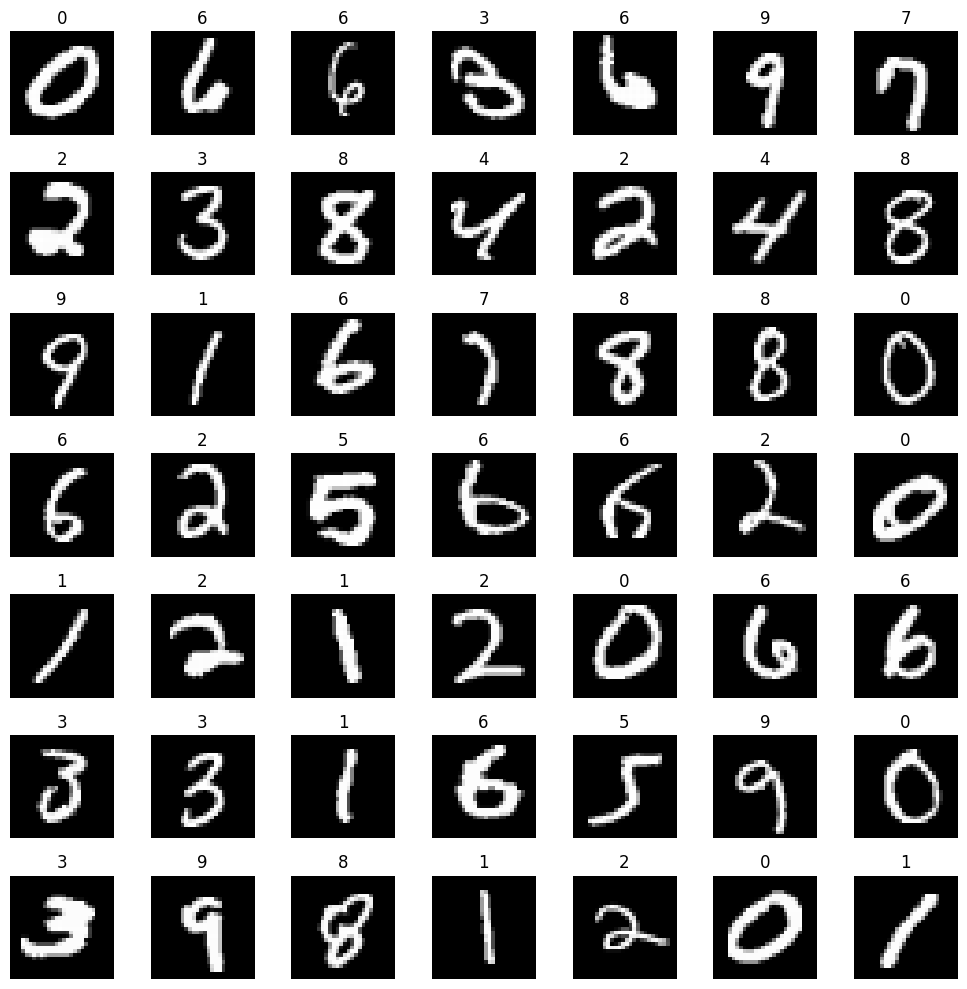

In [10]:
plot_random_mnist_images(test_loader, num_images=49)

### Model for improving Test accuracy
* Adding following transformations based on Test sample analysis:
  * Random Rotation: As there are some digits which are slightly rotated
  * Random Erasing: As there are some digits which are incomplete
* Will introduce batch normalization to get more stable model
* We will also increase number of parameters - specially in the second Convolution block

In [7]:
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)
batch_size = 1024
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomAffine(
                            degrees=15,  # Random rotation up to 10 degrees
                        ),                        
                        transforms.RandomErasing(p=0.1),
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
class MiniCNN_3(nn.Module):
    def __init__(self):
        super(MiniCNN_3, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 28,1>28,8|RF:3,J:1
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 28,8>28,8|RF:5,J:1
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),  # 28,8>28,16|RF:7,J:1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.15)
        )
        self.pool_1 = nn.MaxPool2d(2, 2)  # 28,16>14,16|RF:8,J:2
        self.transition_1 = nn.Conv2d(
            in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False
        )  # 14,16>14,8|RF:8,J:2
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=4, out_channels=8, kernel_size=(3, 3), padding=1, bias=False
            ),  # 14,8>14,8|RF:12,J:2
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),  # 14,8>14,16|RF:16,J:2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                bias=False,
            ),  # 14,16>14,16|RF:20,J:2
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.pool_2 = nn.MaxPool2d(2, 2)  # 14,16>7,16|RF:21,J:4
        self.transition_2 = nn.Conv2d(
            in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False
        )  # 14,16>7,4|RF:21,J:4
        self.fc = nn.Linear(4 * 7 * 7, 10)  # 7,4>10

    def forward(self, x):
        x = self.block_1(x)
        x = self.pool_1(x)
        x = self.transition_1(x)
        x = self.block_2(x)
        x = self.pool_2(x)
        x = self.transition_2(x)
        x = x.view(-1, 4 * 7 * 7)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [9]:
model = MiniCNN_3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 28, 28]             576
       BatchNorm2d-5            [-1, 8, 28, 28]              16
              ReLU-6            [-1, 8, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,152
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
          Dropout-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              64
           Conv2d-13            [-1, 8, 14, 14]             288
      BatchNorm2d-14            [-1, 8,

#### Layerwise Details

| Layer | Input Size | Output Size | Receptive Field | Jump In | Jump Out |
|-------|------------|-------------|-----------------|----------|-----------|
| Conv1 | 28x28x1 | 28x28x8 | 3 | 1 | 1 |
| Conv2 | 28x28x8 | 28x28x8 | 5 | 1 | 1 |
| Conv3 | 28x28x8 | 28x28x16 | 7 | 1 | 1 |
| MaxPool1 | 28x28x16 | 14x14x16 | 8 | 1 | 2 |
| Transition-Conv1 | 14x14x16 | 14x14x4 | 8 | 2 | 2 |
| Conv4 | 14x14x4 | 14x14x8 | 12 | 2 | 2 |
| Conv5 | 14x14x8 | 14x14x16 | 16 | 2 | 2 |
| Conv6 | 14x14x16 | 14x14x16 | 20 | 2 | 2 |
| MaxPool2 | 14x14x16 | 7x7x16 | 21 | 2 | 4 |
| Transition-Conv2 | 7x7x16 | 7x7x4 | 21 | 4 | 4 |
| FC | 7x7x4 | 10 | - | - | - |

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.1,
    patience=1,
    verbose=True,
    min_lr=1e-6,
)

for epoch in range(1, 16):
    print(f"********* Epoch = {epoch} *********")
    train(model, device, train_loader, optimizer, epoch)
    _, acc = test(model, device, test_loader)
    scheduler.step(acc)
    print("LR = ", scheduler.get_last_lr())

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


********* Epoch = 1 *********


loss=0.1862 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.36it/s]


Epoch 1: Train set: Average loss: 0.3854, Accuracy: 52814/60000 (88.02%)




Test set: Average loss: 0.0753, Accuracy: 9756/10000 (97.56%)

LR =  [0.01]
********* Epoch = 2 *********


loss=0.0934 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.49it/s]


Epoch 2: Train set: Average loss: 0.1268, Accuracy: 57606/60000 (96.01%)




Test set: Average loss: 0.0544, Accuracy: 9830/10000 (98.30%)

LR =  [0.01]
********* Epoch = 3 *********


loss=0.0948 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.39it/s]


Epoch 3: Train set: Average loss: 0.1018, Accuracy: 58037/60000 (96.73%)




Test set: Average loss: 0.0517, Accuracy: 9844/10000 (98.44%)

LR =  [0.01]
********* Epoch = 4 *********


loss=0.1110 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.39it/s]


Epoch 4: Train set: Average loss: 0.0926, Accuracy: 58188/60000 (96.98%)




Test set: Average loss: 0.0468, Accuracy: 9861/10000 (98.61%)

LR =  [0.01]
********* Epoch = 5 *********


loss=0.0652 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.54it/s]


Epoch 5: Train set: Average loss: 0.0835, Accuracy: 58382/60000 (97.30%)




Test set: Average loss: 0.0392, Accuracy: 9868/10000 (98.68%)

LR =  [0.01]
********* Epoch = 6 *********


loss=0.0784 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 6: Train set: Average loss: 0.0789, Accuracy: 58431/60000 (97.39%)




Test set: Average loss: 0.0401, Accuracy: 9871/10000 (98.71%)

LR =  [0.01]
********* Epoch = 7 *********


loss=0.0717 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.53it/s]


Epoch 7: Train set: Average loss: 0.0755, Accuracy: 58513/60000 (97.52%)




Test set: Average loss: 0.0304, Accuracy: 9892/10000 (98.92%)

LR =  [0.01]
********* Epoch = 8 *********


loss=0.0469 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.39it/s]


Epoch 8: Train set: Average loss: 0.0712, Accuracy: 58598/60000 (97.66%)




Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)

LR =  [0.01]
********* Epoch = 9 *********


loss=0.0634 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.52it/s]


Epoch 9: Train set: Average loss: 0.0682, Accuracy: 58631/60000 (97.72%)




Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

LR =  [0.01]
********* Epoch = 10 *********


loss=0.0770 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.44it/s]


Epoch 10: Train set: Average loss: 0.0672, Accuracy: 58675/60000 (97.79%)




Test set: Average loss: 0.0254, Accuracy: 9913/10000 (99.13%)

LR =  [0.01]
********* Epoch = 11 *********


loss=0.0579 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]


Epoch 11: Train set: Average loss: 0.0628, Accuracy: 58757/60000 (97.93%)




Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

LR =  [0.001]
********* Epoch = 12 *********


loss=0.0592 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.53it/s]


Epoch 12: Train set: Average loss: 0.0527, Accuracy: 58990/60000 (98.32%)




Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

LR =  [0.001]
********* Epoch = 13 *********


loss=0.0425 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.45it/s]


Epoch 13: Train set: Average loss: 0.0503, Accuracy: 58993/60000 (98.32%)




Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

LR =  [0.001]
********* Epoch = 14 *********


loss=0.0426 batch_id=58: 100%|██████████| 59/59 [00:16<00:00,  3.57it/s]


Epoch 14: Train set: Average loss: 0.0477, Accuracy: 59060/60000 (98.43%)




Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

LR =  [0.001]
********* Epoch = 15 *********


loss=0.0560 batch_id=58: 100%|██████████| 59/59 [00:17<00:00,  3.44it/s]


Epoch 15: Train set: Average loss: 0.0471, Accuracy: 59043/60000 (98.41%)




Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

LR =  [0.001]


#### Observations

* Max Train Accuracy: 98.43%
* Max Test Accuracy: 99.44%
* Image transformation really helped in increasing Test accuracy. Train accuracy has been impacted but it is not overfitting anymore.